<a href="https://colab.research.google.com/github/100479095/Predictor_F1_2025/blob/main/entrenamiento_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**INTRODUCCIÓN**

---

En este notebook se muestra el entrenamiento de varios modelos de IA para predecir las posiciones del último Gran Premio de Fórmula 1 de 2025, Abu Dabi. Para ello se realizó previamente un  preprocesado de los datos, recopilados de kaggle, lo cuáles se pueden encontrar en el fichero "f1_trainning_data_2016_onwards.csv". En este notebook se eliminarán algunas columnas de este csv con el objetivo de tener un dataset genérico y realizará una validación cruzada entre distintos modelos para encontrar el mejor, el cuál será utilizado para predecir los resultados finales del GP.


#**Carga de datos**

---

Primero que todo importamos las distintas librearís que estaremos utilizando a lo largo del entrenamiento y la validación cruzada.

In [2]:
#Importamos las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

Cargamos los datos del **csv f1_training_data_2014_onwards.csv**, es importante recordar que este fichero es **generado por el script de carga de python** y para lograr que el código se ejecute de manera correcta hay que **subirlo a la plataforma de google colab**.

In [3]:
df = pd.read_csv('f1_training_data_2014_onwards.csv')
#mostramos las primeras 5 filas
print(df.head())

   RACEID  DRIVERID  CONSTRUCTORID  CIRCUITID  ROUND  YEAR  LAP DISTANCE KM  \
0     900         1            131          1      1   -11            5.278   
1     900         3            131          1      1   -11            5.278   
2     900         4              6          1      1   -11            5.278   
3     900         8              6          1      1   -11            5.278   
4     900        13              3          1      1   -11            5.278   

   LAPS RACE  URBAN  AVG WIND SPEED  ...        Q2        Q3   BEST Q  GRID  \
0         57      0           26.75  ...  102890.0  104231.0  91699.0     1   
1         57      0           26.75  ...  102264.0  104595.0  92564.0     3   
2         57      0           26.75  ...  102805.0  105819.0  91388.0     5   
3         57      0           26.75  ...  104494.0  300000.0  92439.0    11   
4         57      0           26.75  ...  104242.0  108079.0  91228.0     9   

   Q1 VALID  Q2 VALID  Q3 VALID  RACE VALID  SPRIN

## Limpieza de ID

En este apartadp eliminamos las columnas de RACEID y DRIVERID ya que son únicas o muy específicas y queremos que nuestro modelo sea capaz de generalizar entre los datos.

In [16]:
# 1. Asegurar que el DataFrame está ordenado cronológicamente
df = df.sort_values(by=['YEAR', 'ROUND'])

# 2. Definir el corte.
#Escogemos el año 2024 para tener las carreras a partir de este año como test
ultimo_anio = df['YEAR'].max() -1

train_data = df[df['YEAR'] < ultimo_anio]
test_data = df[df['YEAR'] >= ultimo_anio]

#, 'CONSTRUCTORID', 'CIRCUITID', 'Q1', 'Q2', 'Q3'
cols_to_drop = ['RACEID', 'DRIVERID', 'MS RACE']
#X = df.drop(columns=cols_to_drop)
X_train = train_data.drop(columns=cols_to_drop)
y_train = np.log1p(train_data['MS RACE'])

# Transformación Logarítmica de los ms
#y = np.log1p(df['MS RACE'])
X_test = test_data.drop(columns=cols_to_drop)
y_test = np.log1p(test_data['MS RACE'])

print(f"Entrenando con {len(X_train)} registros (años anteriores)")
print(f"Testeando con {len(X_test)} registros (año más reciente)")

#Diferenciamos los atributos categoricos de los numericos
categorical_features = ['CONSTRUCTORID', 'CIRCUITID']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

#Creamos el pipeline de transformación
preprocessor = ColumnTransformer(
    transformers=[
        # Escalar numéricas para que el modelo no se sesgue por magnitudes grandes
        ('num', StandardScaler(), numerical_features),
        # Convertir IDs a vectores binarios (One-Hot)
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


Entrenando con 4147 registros (años anteriores)
Testeando con 938 registros (año más reciente)


## Definición y Evaluación de Modelos de Regresión

---

Para lograr la regresión vamos a seleccionar el mejor entre 3 modelos (Random Forest, MLP o GradientBoost)



Evaluamos los modelos por validación cruzada:
RandomForestRegressor: 0.2532 (+/- 0.1823)
MLPRegressor: 0.8801 (+/- 0.4072)
GradientBoostingRegressor: 0.2389 (+/- 0.1721)


/tmp/ipython-input-1938072642.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels=names, showmeans=True)


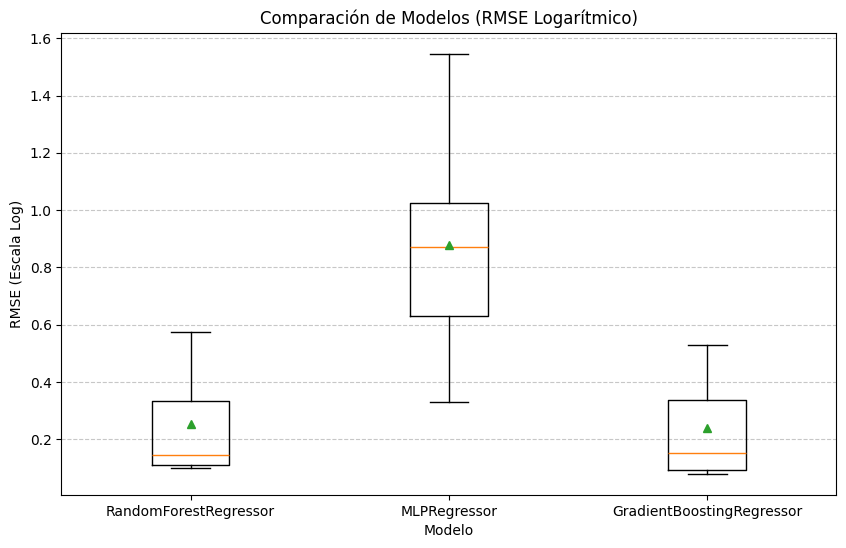

In [17]:
#Modelos a evaluar
models = [
    ('RandomForestRegressor', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('MLPRegressor', MLPRegressor(max_iter=500, random_state=42)),
    ('GradientBoostingRegressor', GradientBoostingRegressor(random_state=42))
]

#Hacemos un split de los datos, stratificado por año
#X_train, X_test, y_train, y_test = train_test_split(
    #X, y, test_size=0.2, random_state=42, stratify=X['YEAR']
#)
#print("Distribución de 'YEAR' en X_train:")
#print(X_train['YEAR'].value_counts(normalize=True).sort_index())

#print("\nDistribución de 'YEAR' en X_test:")
#print(X_test['YEAR'].value_counts(normalize=True).sort_index())

#Comenzamos el Kfold y la validación cruzada
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nEvaluamos los modelos por validación cruzada:")
results = []
names = []

for name, model in models:
    #Creamos un pipeline individual para cada modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    #cross_val_score devuelve 'neg_mean_squared_error'por lo que lo negamos y sacamos raíz
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    rmse_scores = np.sqrt(-cv_scores)

    results.append(rmse_scores)
    names.append(name)
    print(f"{name}: {rmse_scores.mean():.4f} (+/- {rmse_scores.std():.4f})")

# Configuración del tamaño del gráfico
plt.figure(figsize=(10, 6))

# Crear el diagrama de caja (boxplot) usando tus variables 'results' y 'names'
plt.boxplot(results, labels=names, showmeans=True)

# Añadir títulos y etiquetas
plt.title('Comparación de Modelos (RMSE Logarítmico)')
plt.ylabel('RMSE (Escala Log)')
plt.xlabel('Modelo')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()

## Optimización de Hiperparámetros



In [18]:
#Escogemos el mejor modelo del apartado anterior, en nuestro caso GradientBoostingRegressor
best_model_name = 'GradientBoostingRegressor'
best_model = None
for name, model in models:
    if name == best_model_name:
        best_model = model
        break
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', best_model)])
#Definimos los parámetros para el GridSearch
param_grid = {
    #[100, 200, 300]
    'model__n_estimators': [100],
    #[0.01, 0.05, 0.1]
    'model__learning_rate': [0.1],
    #[3, 4, 5]
    'model__max_depth': [4]
}

#Inicializamos el Grid Search
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

#Realizamos el Grid Search
grid_search.fit(X_train, y_train)


#Imprimimos resultados
print(f"\nLos mejores parametros para {best_model_name} son: {grid_search.best_params_}")
print(f"El mejor score de la validación cruzada (neg_mean_squared_error) para {best_model_name} fue: {grid_search.best_score_:.4f}")
print(f"El mejor RMSE para {best_model_name} fue: {np.sqrt(np.abs(grid_search.best_score_)):.4f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Los mejores parametros para GradientBoostingRegressor son: {'model__learning_rate': 0.1, 'model__max_depth': 4, 'model__n_estimators': 100}
El mejor score de la validación cruzada (neg_mean_squared_error) para GradientBoostingRegressor fue: -0.0012
El mejor RMSE para GradientBoostingRegressor fue: 0.0343


## Entrenamiento del Modelo Final y Predicción




In [19]:

#Escogemos el mejor modelo de la validación cruzada
best_model_final = grid_search.best_estimator_

#Predecimos el resultado y lo regresamos a la escala original (ms)
y_pred_log = best_model_final.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test)

#Métricas de evaluación
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)

print(f"RMSE (en ms): {rmse:,.0f}")
print(f"MAPE (Error Porcentual): {mape:.2%}")
print(f"R-squared (R2): {r2:.4f}")


RMSE (en ms): 589,483
MAPE (Error Porcentual): 7.31%
R-squared (R2): 0.8616


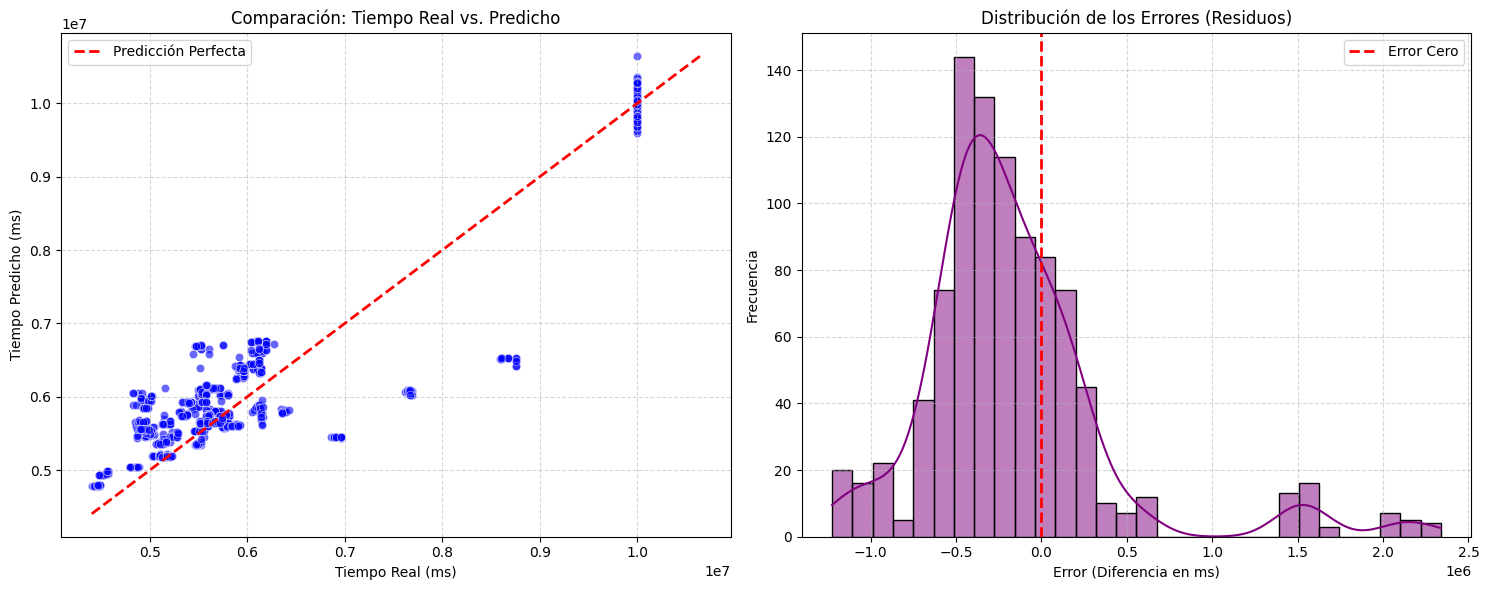

In [20]:
# Calculamos los residuos (diferencia entre lo real y lo predicho)
residuals = y_test - y_pred

# Configuración de los gráficos
plt.figure(figsize=(15, 6))

# GRÁFICO 1: Dispersión (Scatter Plot) - Real vs Predicho
plt.subplot(1, 2, 1)
# Dibujamos los puntos
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')

# Dibujamos la línea de "Predicción Perfecta" (y = x)
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')

plt.title('Comparación: Tiempo Real vs. Predicho')
plt.xlabel('Tiempo Real (ms)')
plt.ylabel('Tiempo Predicho (ms)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)


# GRÁFICO 2: Distribución de Errores (Histograma de Residuos)
plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(x=0, color='red', linestyle='--', lw=2, label='Error Cero')

plt.title('Distribución de los Errores (Residuos)')
plt.xlabel('Error (Diferencia en ms)')
plt.ylabel('Frecuencia')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

#Predicción del GP de Abu Dhabi